In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def paths_bsdistr(num_paths: int, fwds: list[float], 
               fwd_times: list[float], vol: float) -> list[list[float]]:
    """
    Black-Scholes geometric brownian motion scheme. Given a number of paths and a list
    of forwards and corresponding times, fixed volatility, generate paths simulating potential
    price change.
    """
    
    assert(fwd_times[0] == 0)
    assert(len(fwds) == len(fwd_times))
    
    paths = [[] for _ in range(num_paths)]
    prev_vals = [fwds[0]] * num_paths
    
    for i in range(len(fwds)):
        for j in range(num_paths):
            if i == 0: # start paths w/ initial expectation "spot price"
                paths[j].append(fwds[i])

            else:
                z = np.random.randn() # Z~N(0, 1)
                prev = prev_vals[j] # most recent prev value of jth path
                dt = fwd_times[i] - fwd_times[i-1]
                
                # gen new value - geometric Brownian motion scheme
                new_val = prev * np.exp((vol * np.sqrt(dt)) * z)
                
                # normalization factor Q
                # s.t. E(path(T+dt) / path(T)) = fwds[S+dt]/fwds[S]
                Q = (fwds[i]/fwds[i-1])*np.exp(-1*((vol**2)*dt)/2)
                
                new_val *= Q
                
                paths[j].append(new_val)
                prev_vals[j] = new_val
    
    return paths


In [5]:
def makeTrivialFwds(value0, numFwds, growth=0.02):
    """
    For testing. Given initial value and number of forwards, growth rate, generate 
    evenly spaced ftimes and forwards with fixed growth.
    """
    res1 = []
    res1.append(value0)
    
    res2 = []
    res2.append(0.0)
    
    for i in range(numFwds-1):
        res1.append(res1[i]*(1+growth))
        res2.append(res2[i]+1.0)
    
    assert(len(res1) == len(res2))
    return res1, res2

def vizPaths(paths, fwds, times):
    """
    Visualize simulated paths around fixed forwards labeled in red.
    """
    assert(len(fwds) == len(times))

    plt.figure(figsize=(12, 8))
    
    xvals = np.array(times)
    fyvals = np.array(fwds)
    plt.plot(xvals, fyvals, color='red', label='Forwards')
    
    for path in paths:
        pyvals = np.array(path)
        plt.plot(xvals, pyvals)

    plt.title(f"Monte Carlo Simulation: {len(paths)} Simulated Paths About {len(fwds)} Forwards")
    plt.xlabel("Time")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.show()
    
    return None

def checkPathMeans(paths, fwds):
    """
    For testing. Given paths and forwards, take ratio between mean of paths and forward at 
    each ftime/fwd index. Expect consistent hovering +/- about 1.
    """
    diffs = []
    for i in range(len(fwds)):
        fwd = fwds[i]
        ptotal = 0
        for path in paths:
            ptotal += path[i]
        pavg = ptotal / len(paths)
        ratio = pavg / fwd
        diffs.append(ratio)
    
    return diffs

In [7]:
def COpricing(paths, ftimes, maturity, strike, textOutput=False):
    """
    Given the MC Simulated paths, a maturity and strike price, return fair price.
    """
    
    assert(maturity in ftimes)
    idx = ftimes.index(maturity)
    
    diffs = []
    for path in paths:
        pprice_ = path[idx]
        diffs.append(max(0, (pprice_ - strike)))

    if (textOutput):
        return f"Simulated {len(paths)} paths with spot price of ${paths[0][0]} for ${strike} strike at {maturity}-year maturity, fair price: ${np.mean(diffs)}"
        
    return  np.mean(diffs)
        

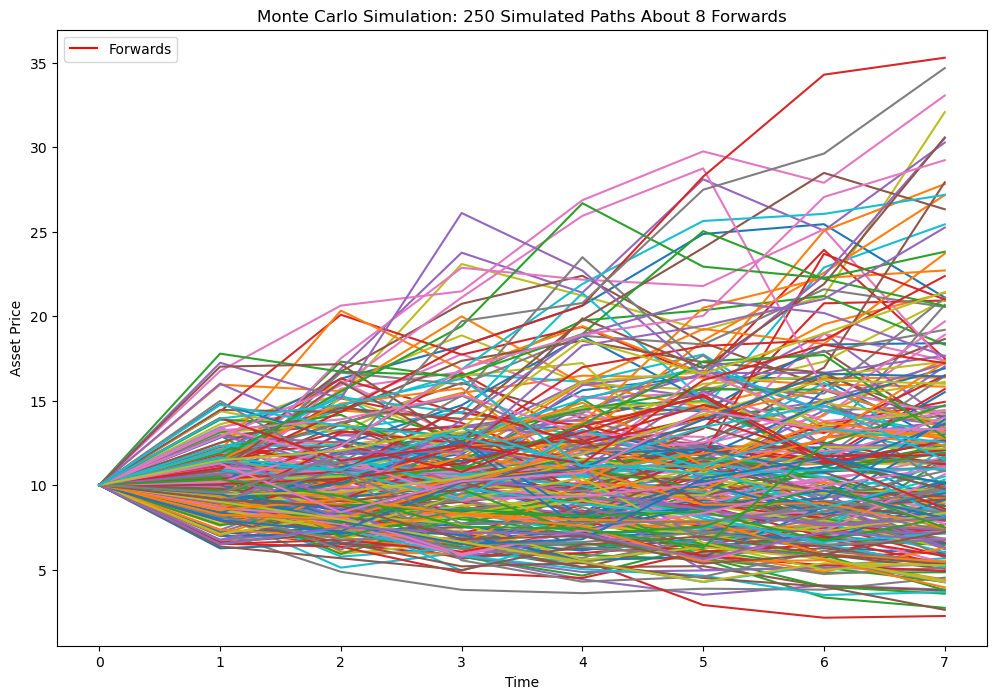

In [9]:
"""
Visualize Simulations
"""

# Sim 1
"""
$10 Initial price, 7 years of 2% risk-free interest growth, 250 paths simulated with vol 0.2.
"""
fwds, fwd_times = makeTrivialFwds(10, 8, 0.02)
num_paths = 250
paths = paths_bsdistr(num_paths, fwds, fwd_times, vol=0.2)
vizPaths(paths, fwds, fwd_times)

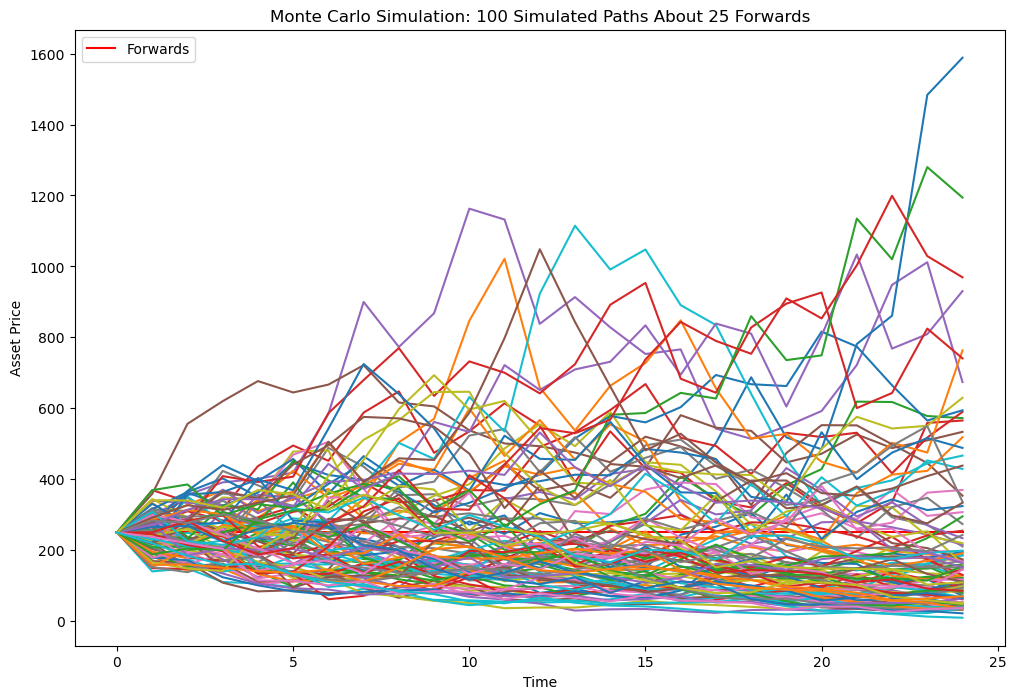

In [11]:
# Sim 2
"""
$250 Initial price, 24 years of 0% risk-free interest growth, 100 paths simulated with vol 0.2.
"""
fwds, fwd_times = makeTrivialFwds(250, 25, 0)
num_paths = 100
paths = paths_bsdistr(num_paths, fwds, fwd_times, vol=0.2)
vizPaths(paths, fwds, fwd_times)

In [ ]:
# Sim 3
"""
$50 Initial price, 500 days of 0.0054% risk-free daily growth, 100000 paths simulated with daily vol 0.0104. 
"""
fwds, fwd_times = makeTrivialFwds(50, 500, 0.000054)
num_paths = 100000
paths = paths_bsdistr(num_paths, fwds, fwd_times, vol=0.0104)
vizPaths(paths, fwds, fwd_times)

In [13]:
"""
Pricing Tests
"""

# Sim 1
"""
$137.49 Initial price, 3 day maturity, assuming ZIRP. Strike at $138.00. Vol 0.4185. Simulating 10000 paths.
=>'Simulated 10000 paths with spot price of $137.49 for $138 strike at 0.00821917808219178-year maturity, fair price: $1.8238850250838783'
"""
fwds = [137.49, 137.49]
ftimes = [0.0, 3/365]
paths = paths_bsdistr(10000, fwds, ftimes, vol=0.4185)
COpricing(paths, ftimes, ftimes[-1], 138, True)

'Simulated 10000 paths with spot price of $137.49 for $138 strike at 0.00821917808219178-year maturity, fair price: $1.8288648438344228'

In [15]:
# Sim 2
"""
$137.49 Initial price, 1 month maturity, assuming ZIRP. Strike at $138.00. Vol 0.4861. Simulating 10000 paths.
=>'Simulated 10000 paths with spot price of $137.49 for $138 strike at 0.08493150684931507-year maturity, fair price: $7.561070615506932'
"""
ftimes = [0.0, 31/365]
paths = paths_bsdistr(10000, fwds, ftimes, vol=0.4861)
COpricing(paths, ftimes, ftimes[-1], 138, True)

'Simulated 10000 paths with spot price of $137.49 for $138 strike at 0.08493150684931507-year maturity, fair price: $7.5399663283579414'

In [17]:
# Sim 3
"""
$137.49 Initial price, ~1 year maturity, assuming ZIRP. Strike at $138.00. Vol 0.5561. Simulating 10000 paths.
=> 'Simulated 10000 paths with spot price of $137.49 for $138 strike at 0.9726027397260274-year maturity, fair price: $28.834801048199715'
"""
ftimes = [0.0, 355/365]
paths = paths_bsdistr(10000, fwds, ftimes, vol=0.5561)
COpricing(paths, ftimes, ftimes[-1], 138, True)

'Simulated 10000 paths with spot price of $137.49 for $138 strike at 0.9726027397260274-year maturity, fair price: $29.386869941819523'

In [19]:
"""
Greeks: Δ, ν
"""

def calculate_delta(S, K, T, vol, num_paths, eps):
    """
    Delta (Δ): Sensitivity to the Underlying Price
    Δ = (∂V/∂S)
    """
    
    np.random.seed(123)

    ftimes = [0.0, T]
    fwds1 = [S, S]

    paths1 = paths_bsdistr(num_paths, fwds1, ftimes, vol)
    price_s = COpricing(paths1, ftimes, ftimes[-1], K)
    
    np.random.seed(123)

    fwds2 = [S+eps, S+eps]
    paths2 = paths_bsdistr(num_paths, fwds2, ftimes, vol)
    price_sp = COpricing(paths2, ftimes, ftimes[-1], K)

    delta = (price_sp - price_s) / eps
    return delta

def calculate_vega(S, K, T, vol, num_path, eps):
    """
    Vega (ν): Sensitivity to Volatility
    ν = (∂V/∂σ)
    """

    np.random.seed(123)

    ftimes = [0.0, T]
    fwds = [S, S]

    paths = paths_bsdistr(num_paths, fwds, ftimes, vol)
    price_s = COpricing(paths, ftimes, ftimes[-1], K)
    
    np.random.seed(123)

    paths = paths_bsdistr(num_paths, fwds, ftimes, vol+eps)
    price_sp = COpricing(paths, ftimes, ftimes[-1], K)

    vega = (price_sp - price_s) / eps
    return vega


In [21]:
calculate_delta(100, 110, 1, 0.3, 10000, 0.001)

0.44114414743745556

In [23]:
calculate_vega(100, 110, 1, 0.3, 10000, 0.001)

53.48049140986433

In [25]:
import yfinance as yf

In [27]:
def sampling_dailymoves_paths(stock, S, Tdays, rate, num_paths):
    """
    Simulates stock price paths based on historical daily moves and risk-free growth embedding.
    
    stock: str, stock ticker symbol (e.g., "NVDA").
    S: float, current stock price.
    Tdays: int, number of real-world days to maturity.
    rate: float, annualized risk-free rate (e.g., 0.02 => 2%).
    num_paths: int, number of Monte Carlo simulation paths.

    Returns paths: list[list[float]]
    """
    
    trading_days = int((252 / 365) * Tdays) # convert to trading days

    data = yf.download(stock, period="5y", interval="1d")
    if data.empty:
        raise ValueError(f"No data found for stock {stock}")

    closes = data["Close"].values.flatten() # daily close prices

    daily_moves = np.log(closes[1:] / closes[:-1])
    mean_move = np.mean(daily_moves)
    demeaned_moves = daily_moves - mean_move

    daily_growth = rate / 252
    adjusted_moves = demeaned_moves + daily_growth # embed risk free growth ("forwards")

    paths = []
    for _ in range(num_paths):
        path = [S]
        for _ in range(trading_days):
            move = np.random.choice(adjusted_moves) # sample with replacement from adjusted daily moves
            new_price = path[-1] * (1+move)
            path.append(new_price)
        paths.append(path)

    return paths

def viz_movesampling_paths(paths, stock):

    plt.figure(figsize=(12, 8))
    for path in paths[:50000]:
        plt.plot(path, alpha=0.8)
    plt.title(f"Simulated Price Paths: {stock}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")
    plt.show()


[*********************100%***********************]  1 of 1 completed


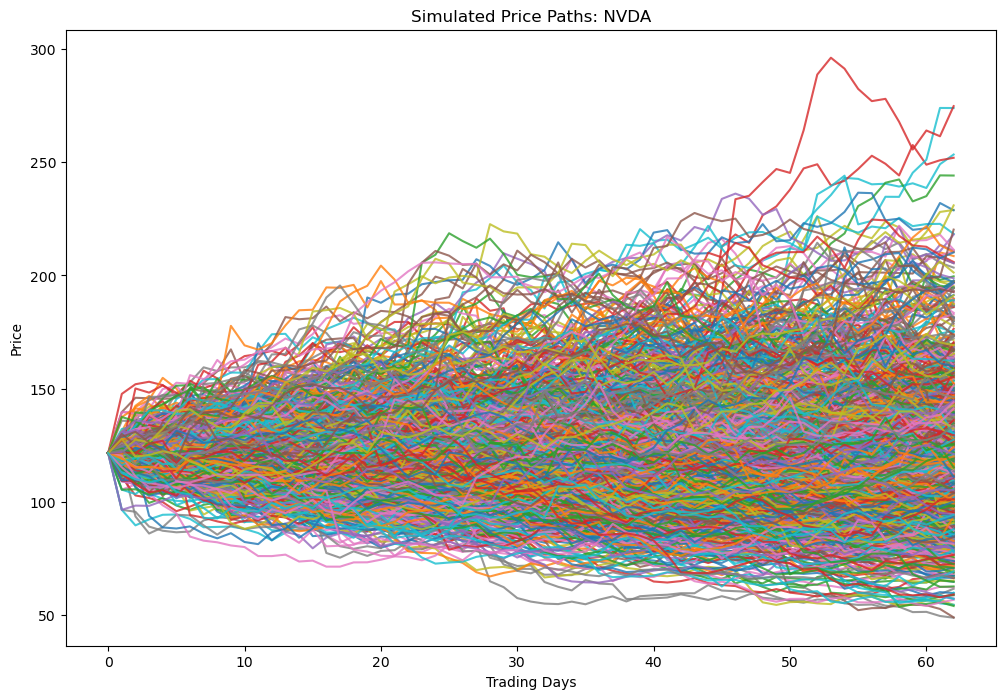

In [29]:
stock = "NVDA"
S = 121.44
Tdays = 90
rate = 0.02
num_paths = 1000

paths = sampling_dailymoves_paths(stock, S, Tdays, rate, num_paths)
viz_movesampling_paths(paths, stock)

[*********************100%***********************]  1 of 1 completed


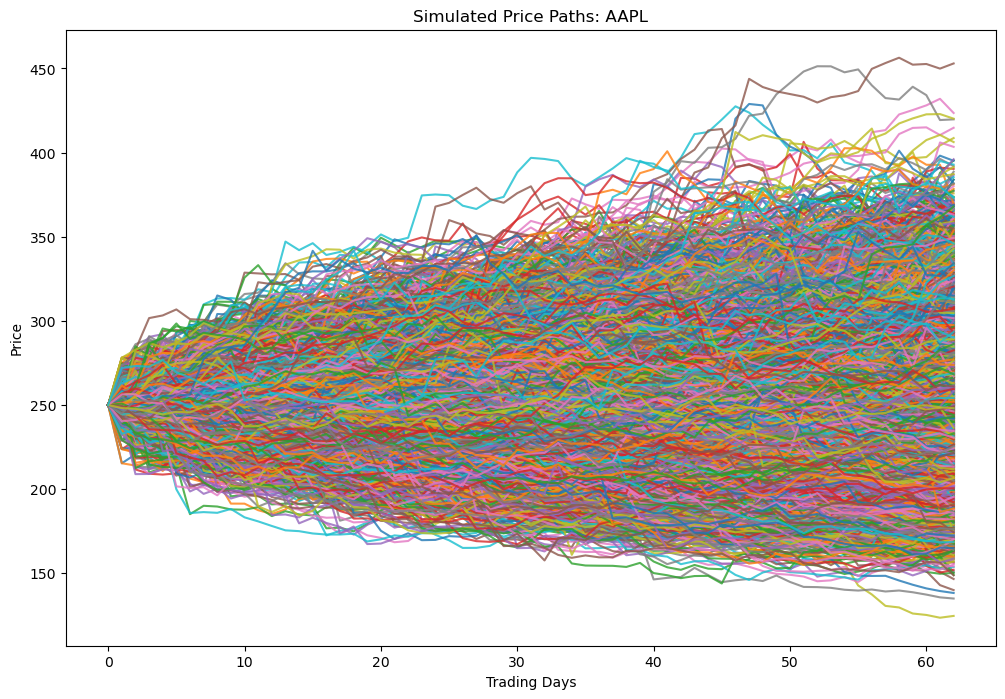

In [31]:
stock = "AAPL"
S = 250
Tdays = 90
rate = 0.02
num_paths = 10000

paths = sampling_dailymoves_paths(stock, S, Tdays, rate, num_paths)
viz_movesampling_paths(paths, stock)

[*********************100%***********************]  1 of 1 completed


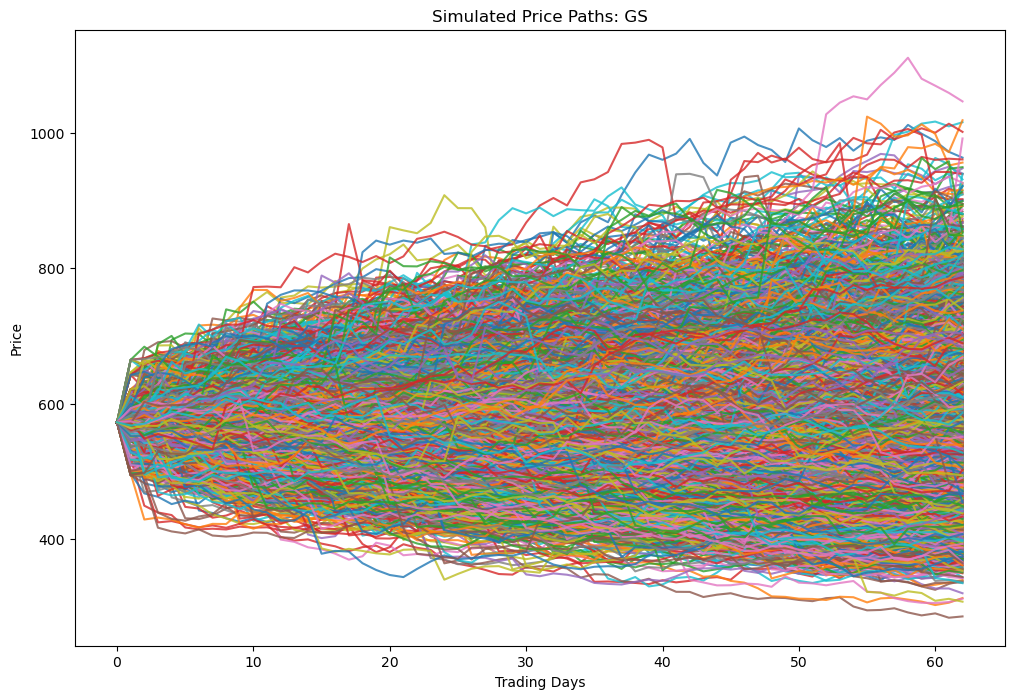

In [33]:
stock = "GS"
S = 572.62
Tdays = 90
rate = 0.02
num_paths = 10000

paths = sampling_dailymoves_paths(stock, S, Tdays, rate, num_paths)
viz_movesampling_paths(paths, stock)

In [35]:
def pricing_call(paths, K, textOutput=False):
    """
    Pricing a call option given simulated paths.
    Assumes maturity of the option is as simulated, i.e. considering final point of each path
    """
    total = 0
    for path in paths:
        total += max(0, path[-1]-K)
    fprice = (total / len(paths))
    if (textOutput):
        return f"Simulated {len(paths)} paths with spot price ${paths[0][0]} for ${K} strike at {len(paths[0])} trading days, CALL fair price ${fprice}"
    return fprice

def pricing_put(paths, K, textOutput=False):

    total = 0
    for path in paths:
        total += max(0, K-path[-1])
        fprice = (total / len(paths))
    if (textOutput):
        return f"Simulated {len(paths)} paths with spot price ${paths[0][0]} for ${K} strike at {len(paths[0])} trading days, PUT fair price ${fprice}"
    return fprice

[*********************100%***********************]  1 of 1 completed


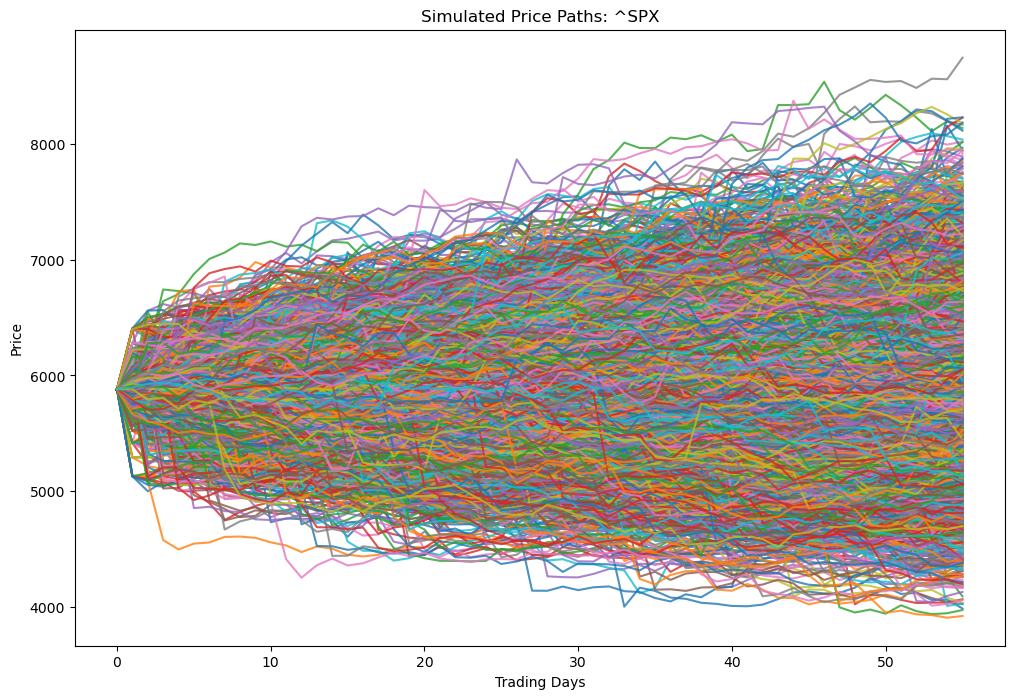

In [37]:
stock = "^SPX"
S = 5881.63
Tdays = 80
rate = 0.02
num_paths = 10000

paths = sampling_dailymoves_paths(stock, S, Tdays, rate, num_paths)
viz_movesampling_paths(paths, stock)

In [39]:
"""
SPX Put Option
=> 'Simulated 10000 paths with spot price $5881.63 for $5000 strike at 56 trading days, PUT fair price $12.677197517887185'
"""
pricing_put(paths, 5000, textOutput=True)

'Simulated 10000 paths with spot price $5881.63 for $5000 strike at 56 trading days, PUT fair price $14.698903058019344'

In [41]:
"""
AAPL Call Option
=> 'Simulated 10000 paths with spot price $250 for $250 strike at 63 trading days, CALL fair price $16.451207225187776'
"""
paths = sampling_dailymoves_paths("AAPL", S=250, Tdays=90, rate=0.02, num_paths=10000)
pricing_call(paths, 250, textOutput=True)

[*********************100%***********************]  1 of 1 completed


'Simulated 10000 paths with spot price $250 for $250 strike at 63 trading days, CALL fair price $16.391997667686148'

In [42]:
"""
AAPL out of the money call option
=>'Simulated 10000 paths with spot price $250 for $350 strike at 63 trading days, CALL fair price $0.31198943305601606'
"""
pricing_call(paths, 350, textOutput=True)

'Simulated 10000 paths with spot price $250 for $350 strike at 63 trading days, CALL fair price $0.3145771432217539'

In [45]:
"""
NVDA at the money call option
=>'Simulated 10000 paths with spot price $134.29 for $134.29 strike at 125 trading days, CALL fair price $20.601987854935565'
"""
paths = sampling_dailymoves_paths("NVDA", S=134.29, Tdays=180, rate=0.02, num_paths=10000)
pricing_call(paths, 134.29, textOutput=True)

[*********************100%***********************]  1 of 1 completed


'Simulated 10000 paths with spot price $134.29 for $134.29 strike at 125 trading days, CALL fair price $21.235513635309385'

In [67]:
def viz_vol_effect(S, K, Tdays, rate, n):
    
    vols = np.linspace(0, 0.9, n)
    
    trading_days = int(Tdays * (252/365))
    daily_rate = rate/252
    final_val = S*((1+daily_rate)**trading_days)

    fwds = [S, final_val]
    ftimes = [0, trading_days/252]
    
    parr = [0]*n
    for i in range(len(vols)):
        vol = vols[i]
        np.random.seed(224)
        paths = paths_bsdistr(1000, fwds, ftimes, vol)
        price = COpricing(paths, ftimes, ftimes[-1], K)
        parr[i] = price

    yvals = np.array(parr)
    
    plt.plot(vols, yvals, color='red') 
    plt.title("Effect of Volatility on Call Price")
    plt.xlabel("Volatility")
    plt.ylabel("Price")
    plt.show()


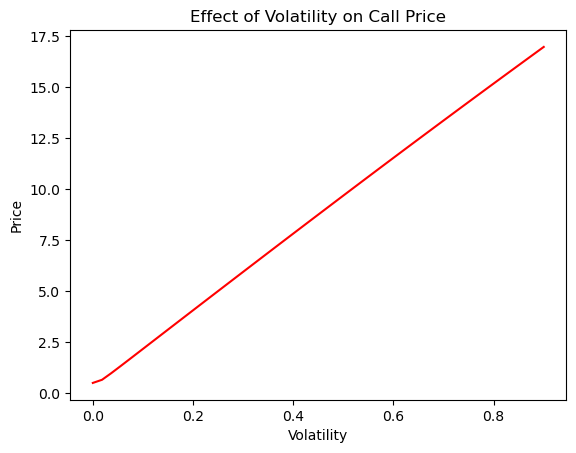

In [69]:
viz_vol_effect(100, 100, 90, 0.02, 50)